In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split,Dataset
from torch.nn import functional as F
import torchvision
from torchvision import datasets,transforms
import torchvision.transforms as transforms

from torch.distributions.normal import Normal

import os
import math
from tqdm import tqdm

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from typing import List

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#Script allow collab to get access to our shared Drive 
#If you are not he owner of the drive make sure you add ATML_HT22 shortcut to your drive or find other workaround 
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path.append('drive/MyDrive/ATML_HT22')

from train import train_and_test
from eval import BinaryMNIST

%load_ext autoreload
%autoreload 2

Mounted at /content/drive


In [ ]:
from utils import load_model

model, optimizer, steps, train_losses, settings = load_model("k10_bMNIST_v2", DEVICE)
batch_size, optim_lr, rms_prop_momentum, num_training_steps,\
imp_samples, D, encoder_hidden_dims, decoder_hidden_dims, latent_size,\
maxout_window_size, non_linearity, optim_type, flow_type, num_flow_blocks, binary = settings

train_loader, test_loader = BinaryMNIST(batch_size)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



****
# Reconstructions

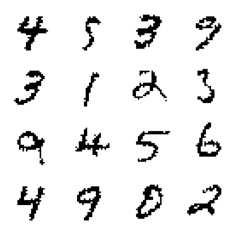

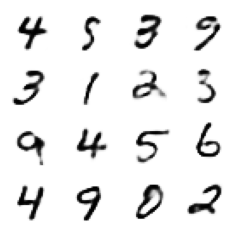

In [ ]:
# Data
for x, _ in train_loader:
  break

f = plt.figure(figsize = (4,4))
#f.suptitle("Test Data")
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.imshow(x[i].squeeze(0), cmap='Greys')
  plt.axis('off')
plt.show()

# Reconstructions
f = plt.figure(figsize = (4,4))
#f.suptitle("Test Reconstructions")
model.eval()

with torch.no_grad():
  x = x.flatten(1).to(DEVICE)
  recon, _, _, _ = model(x)

  for i in range(16):
    plt.subplot(4, 4, i+1)

    plt.imshow(recon[i].cpu().view(-1, 28), cmap='Greys')
    plt.axis('off')

  plt.show()

****
# Interpolations

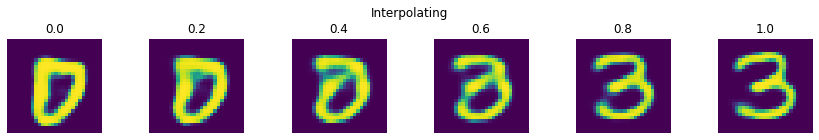

In [ ]:
def lerp(a, b, t):
  return a + (b - a) * t

for x, _ in train_loader:
  break

with torch.no_grad():
  x = x.flatten(1).to(DEVICE)

  mu, logvar, _ = model.encoder(x)
  z_o = model.reparameterize(mu, logvar)
  z_k, _ = model.flow(z_o)

f = plt.figure(figsize = (12, 2))
plt.suptitle("Interpolating")
with torch.no_grad():
  for i, t in enumerate(np.arange(0, 1.1, 0.2)):
    plt.subplot(1, 6, i+1)

    z = lerp(z_k[0], z_k[1], t)
    img = model.decoder(z.unsqueeze(0)).cpu()
    plt.imshow(img.view(-1, 28))

    plt.title(f"{t:.1f}")
    plt.axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.90])
plt.show()

****
# Random Samples from Latent Space

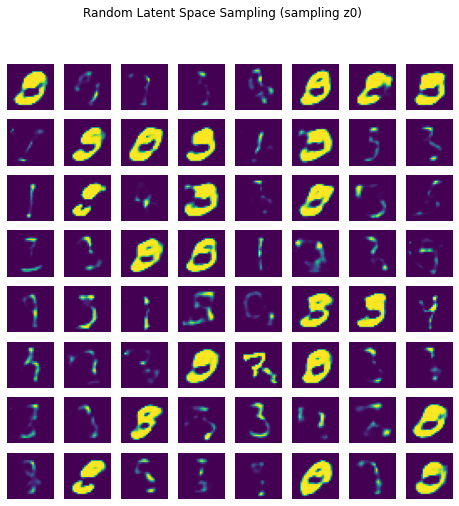

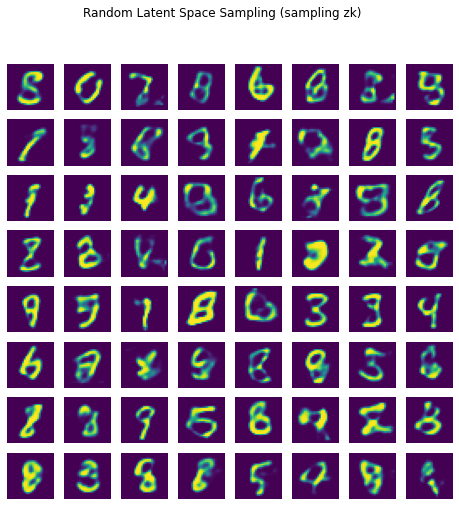

In [ ]:
f = plt.figure(figsize = (8,8))
plt.suptitle("Random Latent Space Sampling (sampling z0)")
with torch.no_grad():
  z = torch.normal(0, 1, size=z_k.shape).to(DEVICE)
  z_k, _ = model.flow(z)

  imgs = model.decoder(z_k).cpu()

  for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(imgs[i].view(-1, 28))
    plt.axis('off')
plt.show()

f = plt.figure(figsize = (8,8))
plt.suptitle("Random Latent Space Sampling (sampling zk)")
with torch.no_grad():

  imgs = model.decoder(z).cpu()

  for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(imgs[i].view(-1, 28))
    plt.axis('off')
plt.show()